# Tutorial: Fit binary model to observed data using nested sampling via UltraNest

In this tutorial we go through the procedure of fitting observations to a binary star model using the nested sampling code [UltraNest](https://johannesbuchner.github.io/UltraNest/).

## Imports and Filter Setup

In [1]:
from phitter import observables, filters
from phitter.params import star_params, binary_params, isoc_interp_params
from phitter.calc import model_obs_calc, phot_adj_calc, rv_adj_calc
from phitter.fit import likelihood, prior

import numpy as np

from phoebe import u
from phoebe import c as const
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle
from astropy.table import Table

import ultranest
import ultranest.stepsampler

%matplotlib inline

# The following warning regarding extinction originates from SPISEA and can be ignored.
# The functionality being warned about is not used by SPISEA.

/Users/abhimatlocal/software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/abhimatlocal/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/abhimatlocal/software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/abhimatlocal/models/cdbs/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
filter_153m = filters.hst_f153m_filt()
filter_127m = filters.hst_f127m_filt()

## Prepare observations data

Let's read in the mock data generated in a [separate example here](create_mock_data). Let's assume this data is for a red giant binary star belonging to an 8 Gyr old star population at the Galactic center.

In [3]:
with open('./mock_obs_table.pkl', 'rb') as in_file:
    obs_table = pickle.load(in_file)

print(obs_table)

    obs_times             obs         obs_uncs obs_types                       obs_filts                       
------------------ ------------------ -------- --------- ------------------------------------------------------
53800.714762925796 16.769110541124228    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312d1e4c0>
 53802.78887450278 16.569960382011555    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312d1e4c0>
 53804.08607971392 16.523859319835843    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312d1e4c0>
 53804.64136070461  16.54425287095397    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312d1e4c0>
53805.203583377115 16.551835703948942    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312d1e4c0>
 53805.96328097839 16.559083907180494    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312d1e4c0>
53806.315847597616 16.526208341236522    0.015      phot <phitter.filters.hst_f153m_filt object at 0x312

We create two new {py:obj}`phitter.observables` objects, one for modeling containing only the times, filters, and types of observations, and another for computing the likelihood, which will also contain the observations and associated uncertainties as well.

In [4]:
# Model observables object, which only contains times and types of observations
model_observables = observables.observables(
    obs_times=obs_table['obs_times'].data,
    obs_filts=obs_table['obs_filts'].data, obs_types=obs_table['obs_types'].data,
)

# An observables object for the observations, used when computing likelihoods
observations = observables.observables(
    obs_times=obs_table['obs_times'].data, obs=obs_table['obs'].data, obs_uncs=obs_table['obs_uncs'].data,
    obs_filts=obs_table['obs_filts'].data, obs_types=obs_table['obs_types'].data,
)

## Make stellar parameters and binary parameters objects for fitting

Now we can make a stellar parameters object that we will use to derive the stellar parameters from an isochrone while fitting. Let's use our previous assumptions about what type of star this is: red giant in an 8 Gyr old star population.

We also can create a binary parameters object that will store the binary parameters.

In [5]:
isoc_stellar_params_obj = isoc_interp_params.isoc_mist_stellar_params(
    age=8e9,
    met=0.0,
    use_atm_func='merged',
    phase='RGB',
    ext_Ks=2.2,
    dist=8e3*u.pc,
    filts_list=[filter_153m, filter_127m],
    ext_law='NL18',
)

# Make binary params objects
bin_params = binary_params.binary_params()

## Set up model and likelihood objects

In order to carry out our fitting, we will generate two more objects: a model object that will be used to compute observables and a likelihood object that will compute the likelihood from our observations.

In [6]:
# Set up a binary model object
binary_model_obj = model_obs_calc.binary_star_model_obs(
    model_observables,
    use_blackbody_atm=False,
    print_diagnostics=False,
)

# Set up likelihood object for fitting parameters
log_like_obj = likelihood.log_likelihood_chisq(
    observations
)

## Set up function for UltraNest to return likelihood from fit parameters

Now we need to write a function that will be used by Ultranest for its sampling. This function will provide Ultranest with a likelihood for a given set of fit parameters.

For our fitting, we'll fit our data to eight parameters:
1. radius of star 1
2. radius of star 2
3. binary orbital period
4. binary inclination
5. system t0
6. binary CoM velocity
7. extinction in F153M passband
8. extinction law alpha

In [7]:
def un_evaluate(model_params):
    (
        star1_radius,
        star2_radius,
        bin_period,
        bin_inc,
        bin_t0,
        bin_rv_com,
        ext_153m,
        ext_alpha,
    ) = model_params
    
    # Obtain stellar params by interpolating along the isochrone
    star1_params = isoc_stellar_params_obj.interp_star_params_rad(
        star1_radius,
    )
    star2_params = isoc_stellar_params_obj.interp_star_params_rad(
        star2_radius,
    )
    
    # Set binary params
    bin_params.period = bin_period * u.d
    bin_params.inc = bin_inc * u.deg
    bin_params.t0 = bin_t0
    
    # Run binary model
    modeled_observables = binary_model_obj.compute_obs(
        star1_params, star2_params, bin_params,
        num_triangles=300,
    )
    
    # Check for situation where binary model fails
    # (i.e., unphysical conditions not able to be modeled)
    if np.isnan(modeled_observables.obs_times[0]):
        return -1e300
    
    # Apply distance modulus
    # (We're assuming we know the distance, but this can be a fit parameter as well)
    modeled_observables = phot_adj_calc.apply_distance_modulus(
        modeled_observables,
        8e3*u.pc,
    )
    
    # Apply extinction
    modeled_observables = phot_adj_calc.apply_extinction(
        modeled_observables,
        2.2, filter_153m,
        ext_153m,
        isoc_red_law='NL18',
        ext_alpha=ext_alpha,
    )
    
    # Add RV center of mass velocity
    modeled_observables = rv_adj_calc.apply_com_velocity(
        modeled_observables,
        bin_rv_com * u.km / u.s,
    )
    
    # Compute and return log likelihood
    log_like = log_like_obj.evaluate(modeled_observables)
    
    return log_like


Let's test out our `un_evaluate()` function on some mock binary parameters

In [8]:
test_params = (
    18., 10.,
    23., 85.,
    53_801.,
    140.,
    4.4, 2.22,
)

log_like_test = un_evaluate(test_params)

print(f'log likelihood from test parameters = {log_like_test:.3f}')

# Since we simulated these mock data ourselves, we know what the "truth" is here. So we can check that as well
truth_params = (
    15., 12.,
    25., 75.,
    53_800.,
    150.,
    4.5, 2.23,
)

log_like_truth = un_evaluate(truth_params)

print(f'log likelihood from "truth" parameters = {log_like_truth:.3f}')

log likelihood from test parameters = -43318.653
log likelihood from "truth" parameters = -64.610


## Set up priors

We need to set up a prior for each of our fit parameters. {py:obj}`phitter.fit.prior` provides some useful functions to create priors and then put them into a collection that can be passed to Ultranest or other sampling codes.

Using the function {py:obj}`phitter.fit.prior.prior_collection.prior_transform_ultranest`, we can transform the unit cube passed in by UltraNest into physical parameters to use during fitting.

In [9]:
star1_rad_prior = prior.uniform_prior(10.0, 25.0)
star2_rad_prior = prior.uniform_prior(8.0, 15.0)

bin_period_prior = prior.uniform_prior(24.0, 26.0)
bin_inc_prior = prior.uniform_prior(0.0, 180.0)
bin_t0_prior = prior.uniform_prior(53_795.0, 53_805.0)
bin_rv_com_prior = prior.uniform_prior(100., 200.)

ext_f153m_prior = prior.uniform_prior(4, 6)
# We have a constraint on the extinction law (from Nogueras-Lara et al., 2019 here),
# so we can set Gaussian prior on the extinction law alpha
ext_alpha_prior = prior.gaussian_prior(2.23, 0.03)

param_priors = prior.prior_collection([
    star1_rad_prior,
    star2_rad_prior,
    bin_period_prior,
    bin_inc_prior,
    bin_t0_prior,
    bin_rv_com_prior,
    ext_f153m_prior,
    ext_alpha_prior,
])

param_names = [
    'star1_rad',
    'star2_rad',
    'bin_period',
    'bin_inc',
    'bin_t0',
    'bin_rv_com',
    'ext_f153m',
    'ext_alpha',
]

# Ultranest supports wrapped / circular parameters, which inclination is in this example.
# So we need to make a list to pass to Ultranest for which parameters are wrapped so that
# it can appropriately handle it during sampling.
wrapped_params = [
    False,  # Star 1 Rad
    False,  # Star 2 Rad
    False,  # Binary period
    True,   # Binary inclination
    False,  # Binary t0
    False,  # Binary CoM RV
    False,  # F153M-band extinction
    False,  # Extinction law alpha
]

## Set up UltraNest Sampler and Run Sampler

In [10]:
sampler = ultranest.ReactiveNestedSampler(
    param_names,
    loglike = un_evaluate,   # Function that we wrote for ultranest to calculate likelihood
    transform = param_priors.prior_transform_ultranest,  # Phitter's prior collection function to transform prior
    log_dir='./un_out/',
    resume='resume-similar',
    warmstart_max_tau=0.25,
)

# Below is an example of how to set up a slice sampler in UltraNest.
# We won't use it here since it is less efficient for this example, but a
# "slice sampler" may be more efficient when fitting a large number
# of parameters (i.e., >~ 10).

# sampler.stepsampler = ultranest.stepsampler.SliceSampler(
#     nsteps=(2**3)*len(param_names),
#     generate_direction=ultranest.stepsampler.generate_mixture_random_direction,
# )

The syntax below shows how to run the sampler. However for speed, I wrote a [separate script](fit_with_ultranest.py) that can be parallelized with MPI. In order to run the example script, the following syntax can be used in the shell:

```sh
mpiexec -np [num_cores] ./fit_with_ultranest.py
```

Importantly, the script demonstrates how to parallelize Ultranest's sampling and turn off parallelization in PHOEBE which can interfere with parallelization in Ultranest:
```py
import os
# Turn off parallelisation in phoebe
# Needs to be done *before* phoebe is imported
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["PHOEBE_ENABLE_MPI"] = "FALSE"
```

Since Ultranest can resume from previous runs, the code block below picks up on the samples from the parallelized script.

In [11]:
result = sampler.run(
    show_status=True,
    update_interval_volume_fraction=0.98,
    frac_remain=0.5,
)

[ultranest] Resuming from 10376 stored points
[ultranest] Widening roots to 452 live points (have 400 already) ...
[ultranest] Widening roots to 512 live points (have 452 already) ...


[ultranest] Explored until L=-4e+01   [-41.0913..-41.0910]*| it/evals=9792/2297388 eff=inf% N=400          0  
[ultranest] Likelihood function evaluations: 2297388


/Users/abhimatlocal/software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -64.05 +- 0.1743
[ultranest] Effective samples strategy satisfied (ESS = 755.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.44, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.17 tail:0.41 total:0.44 required:<0.50
[ultranest] done iterating.


## Examine the fit results

UltraNest offers several outputs and plots to examine the results of our fit. Let's run those here.

In [12]:
sampler.print_results()


logZ = -63.988 +- 0.439
  single instance: logZ = -63.988 +- 0.234
  bootstrapped   : logZ = -64.050 +- 0.168
  tail           : logZ = +- 0.406
insert order U test : converged: True correlation: inf iterations
diagnostic unavailable, no recorded steps found

    star1_rad           : 11.80 │ ▁ ▁▁▁▁▁▁▂▂▃▃▃▃▄▅▇▇▆▇▇▆▅▅▅▄▄▃▂▁▁▁▁▁▁▁▁ │16.06     14.02 +- 0.59
    star2_rad           : 10.15 │ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▆▆▆▇▇▆▇▆▇▄▅▆▄▄▄▃▃▃│15.00     13.45 +- 0.79
    bin_period          : 24.60 │ ▁ ▁▁▁▁▁▁▃▃▃▄▄▄▆▇▆▇▆▆▅▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │25.59     25.06 +- 0.13
    bin_inc             : 71    │ ▁▂▇▃▁                           ▁▂▇▃▁ │109       89 +- 16
    bin_t0              : 53799.686│ ▁▁▁ ▁▁▁▁▁▁▂▂▂▃▅▄▆▆▇▆▇▆▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁ │53800.248    53799.978 +- 0.067
    bin_rv_com          : 133.5 │ ▁▁▁▁▁▁▁▁▁▁▃▂▃▅▅▆▆▇▇▇▆▅▇▅▃▃▃▂▂▁▁▁▁▁▁▁▁ │157.9     146.0 +- 3.2
    ext_f153m           : 4.367 │ ▁   ▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▆▆▆▇▅▇▄▄▃▃▁▂▁▁▁▁▁▁ │4.657     4.536 +- 0.035
    ext_alpha           : 2.165 │ ▁ ▁▁▁▁▁▁▂▃▄▄▅▇▇▆▇▅▆▅

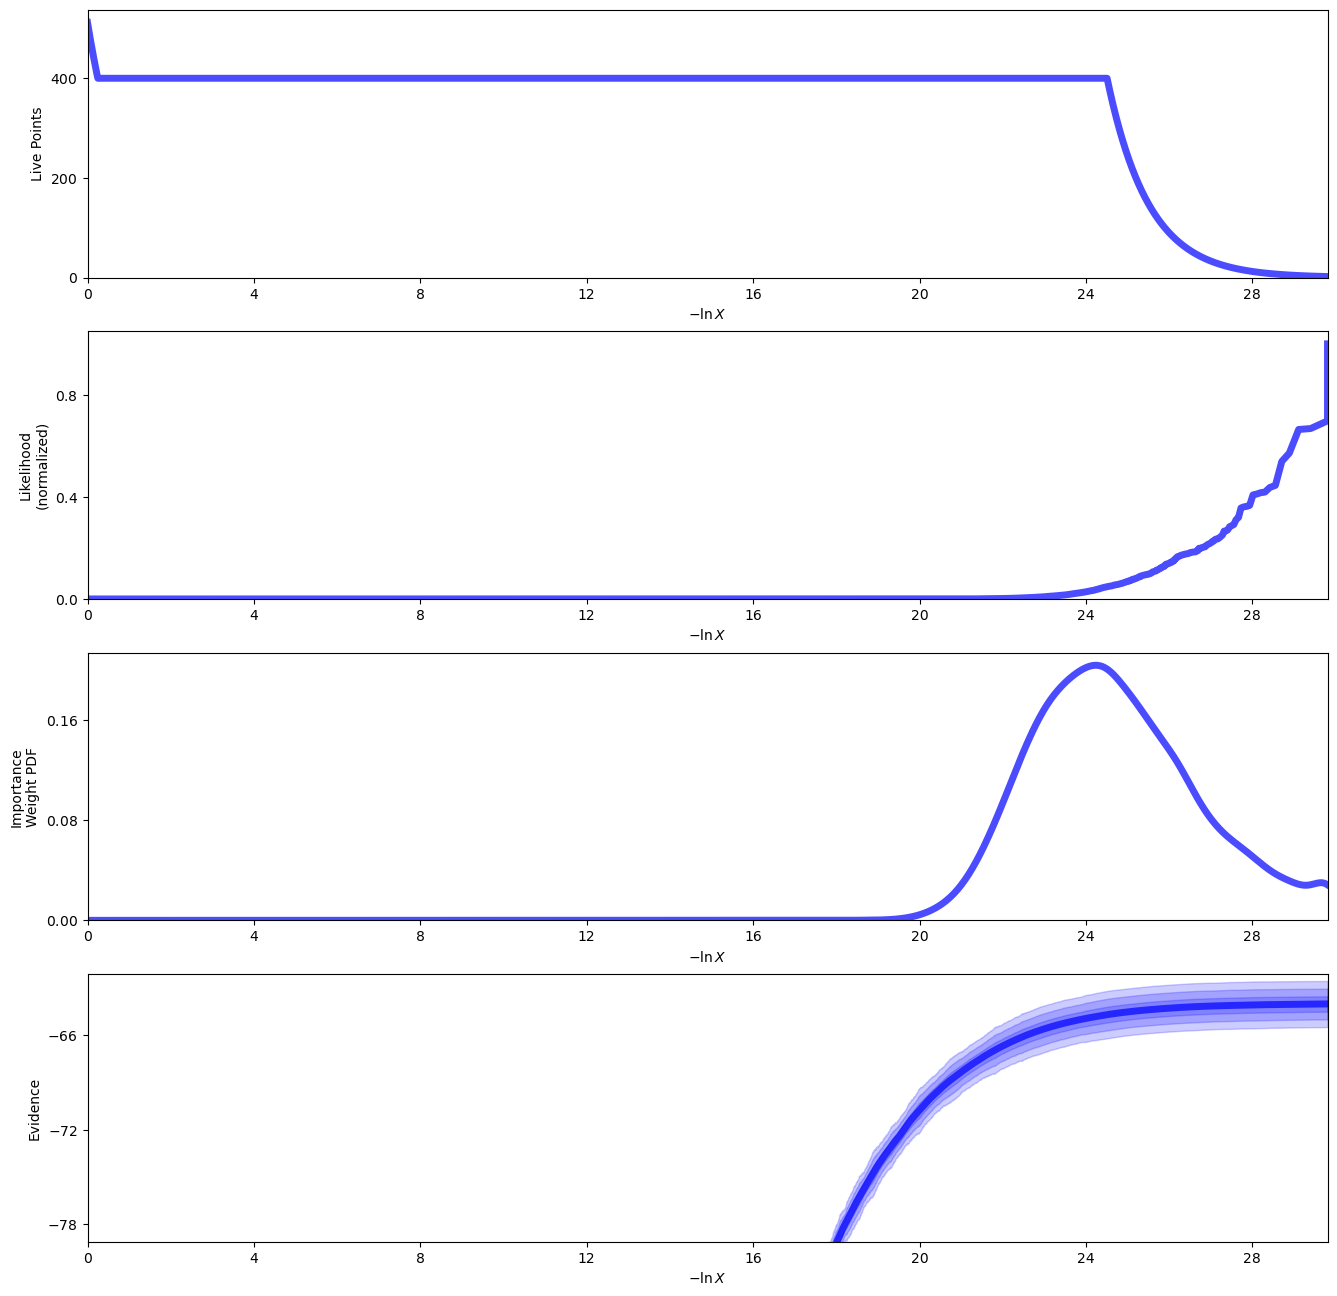

In [13]:
sampler.log_to_disk = False
sampler.plot_run()

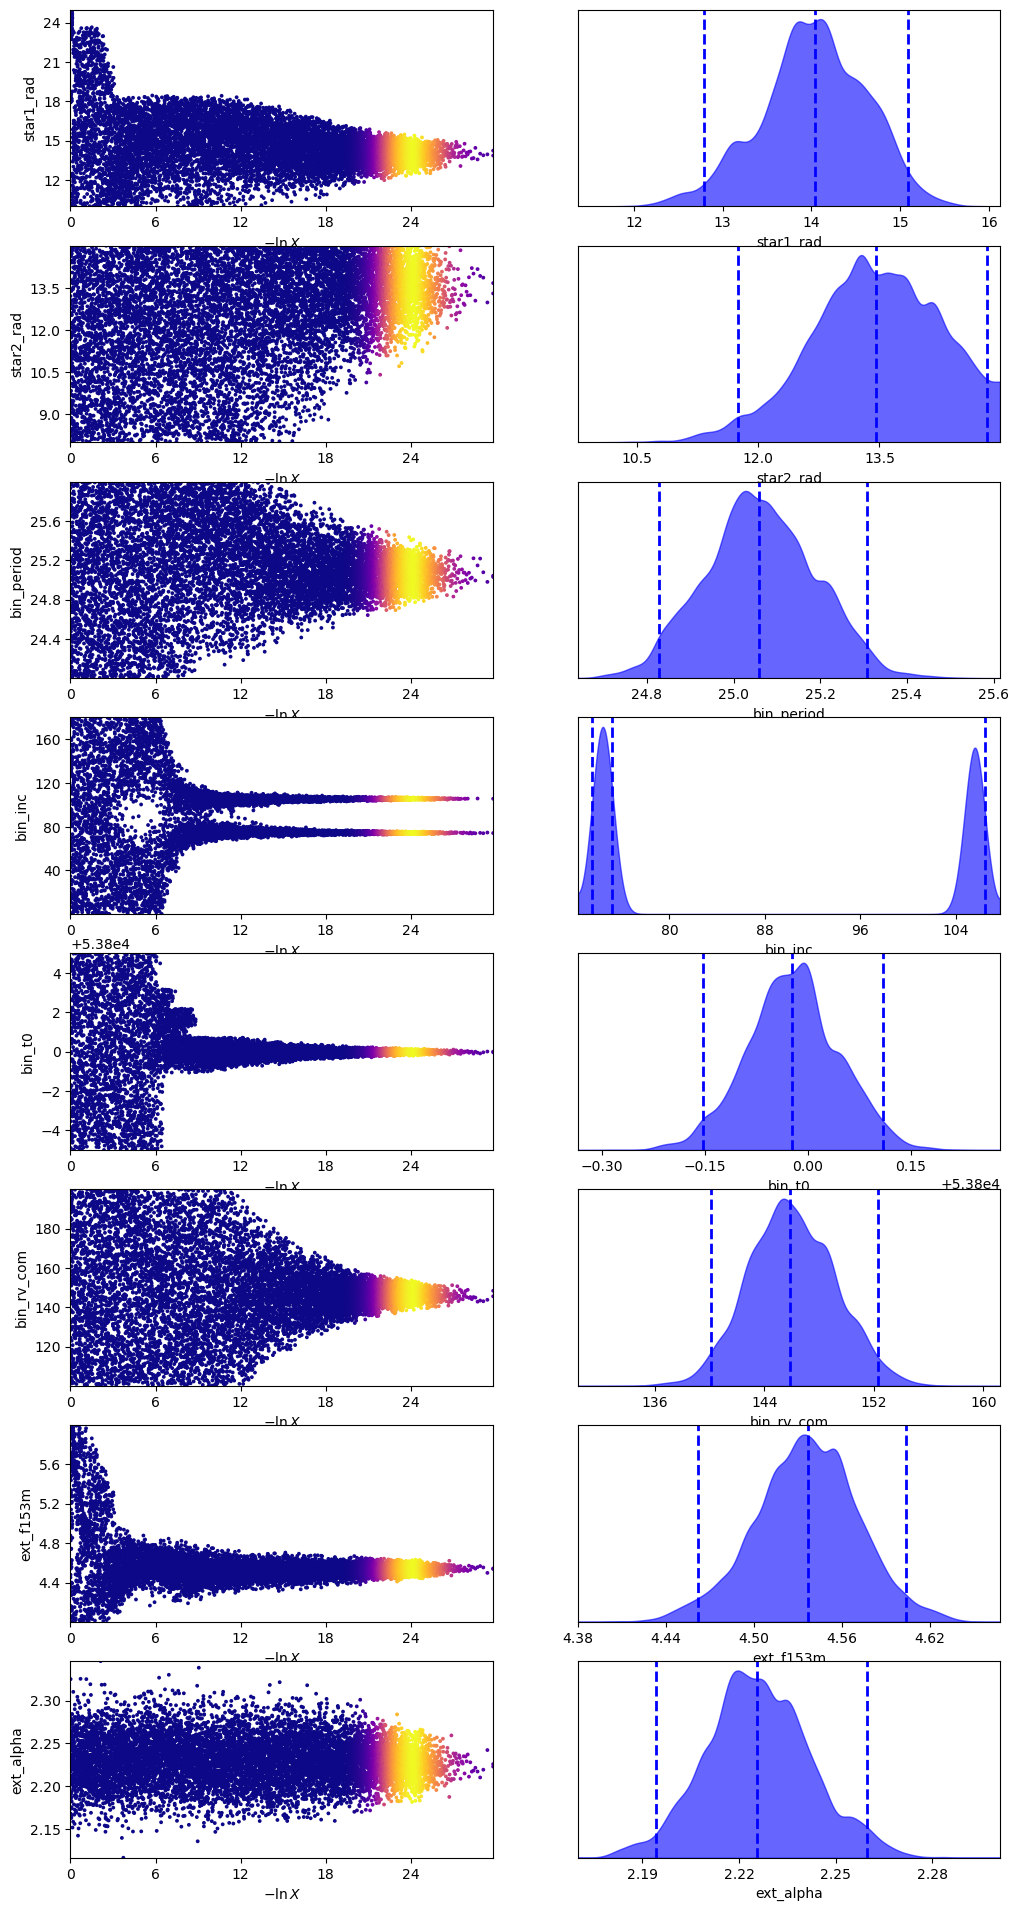

In [14]:
sampler.plot_trace()

The corner plot may be particularly useful to examine the constraints on the parameters from our fit. We’ll also put in the “truth” values in here (shown as blue lines), corresponding to the value of each parameter with which we generated the mock data.

The fit recovers the generated parameters. For the stellar radii and the center of mass RV, our "truth" value appears to be slightly out of 1 sigma, but still within the 95% confidence bounds. Also note the degeneracy in inclination, which is to be expected. The UltraNest fit recovers a peak at both the mock inclination, $i$, and a peak at $(180\degree - i)$.

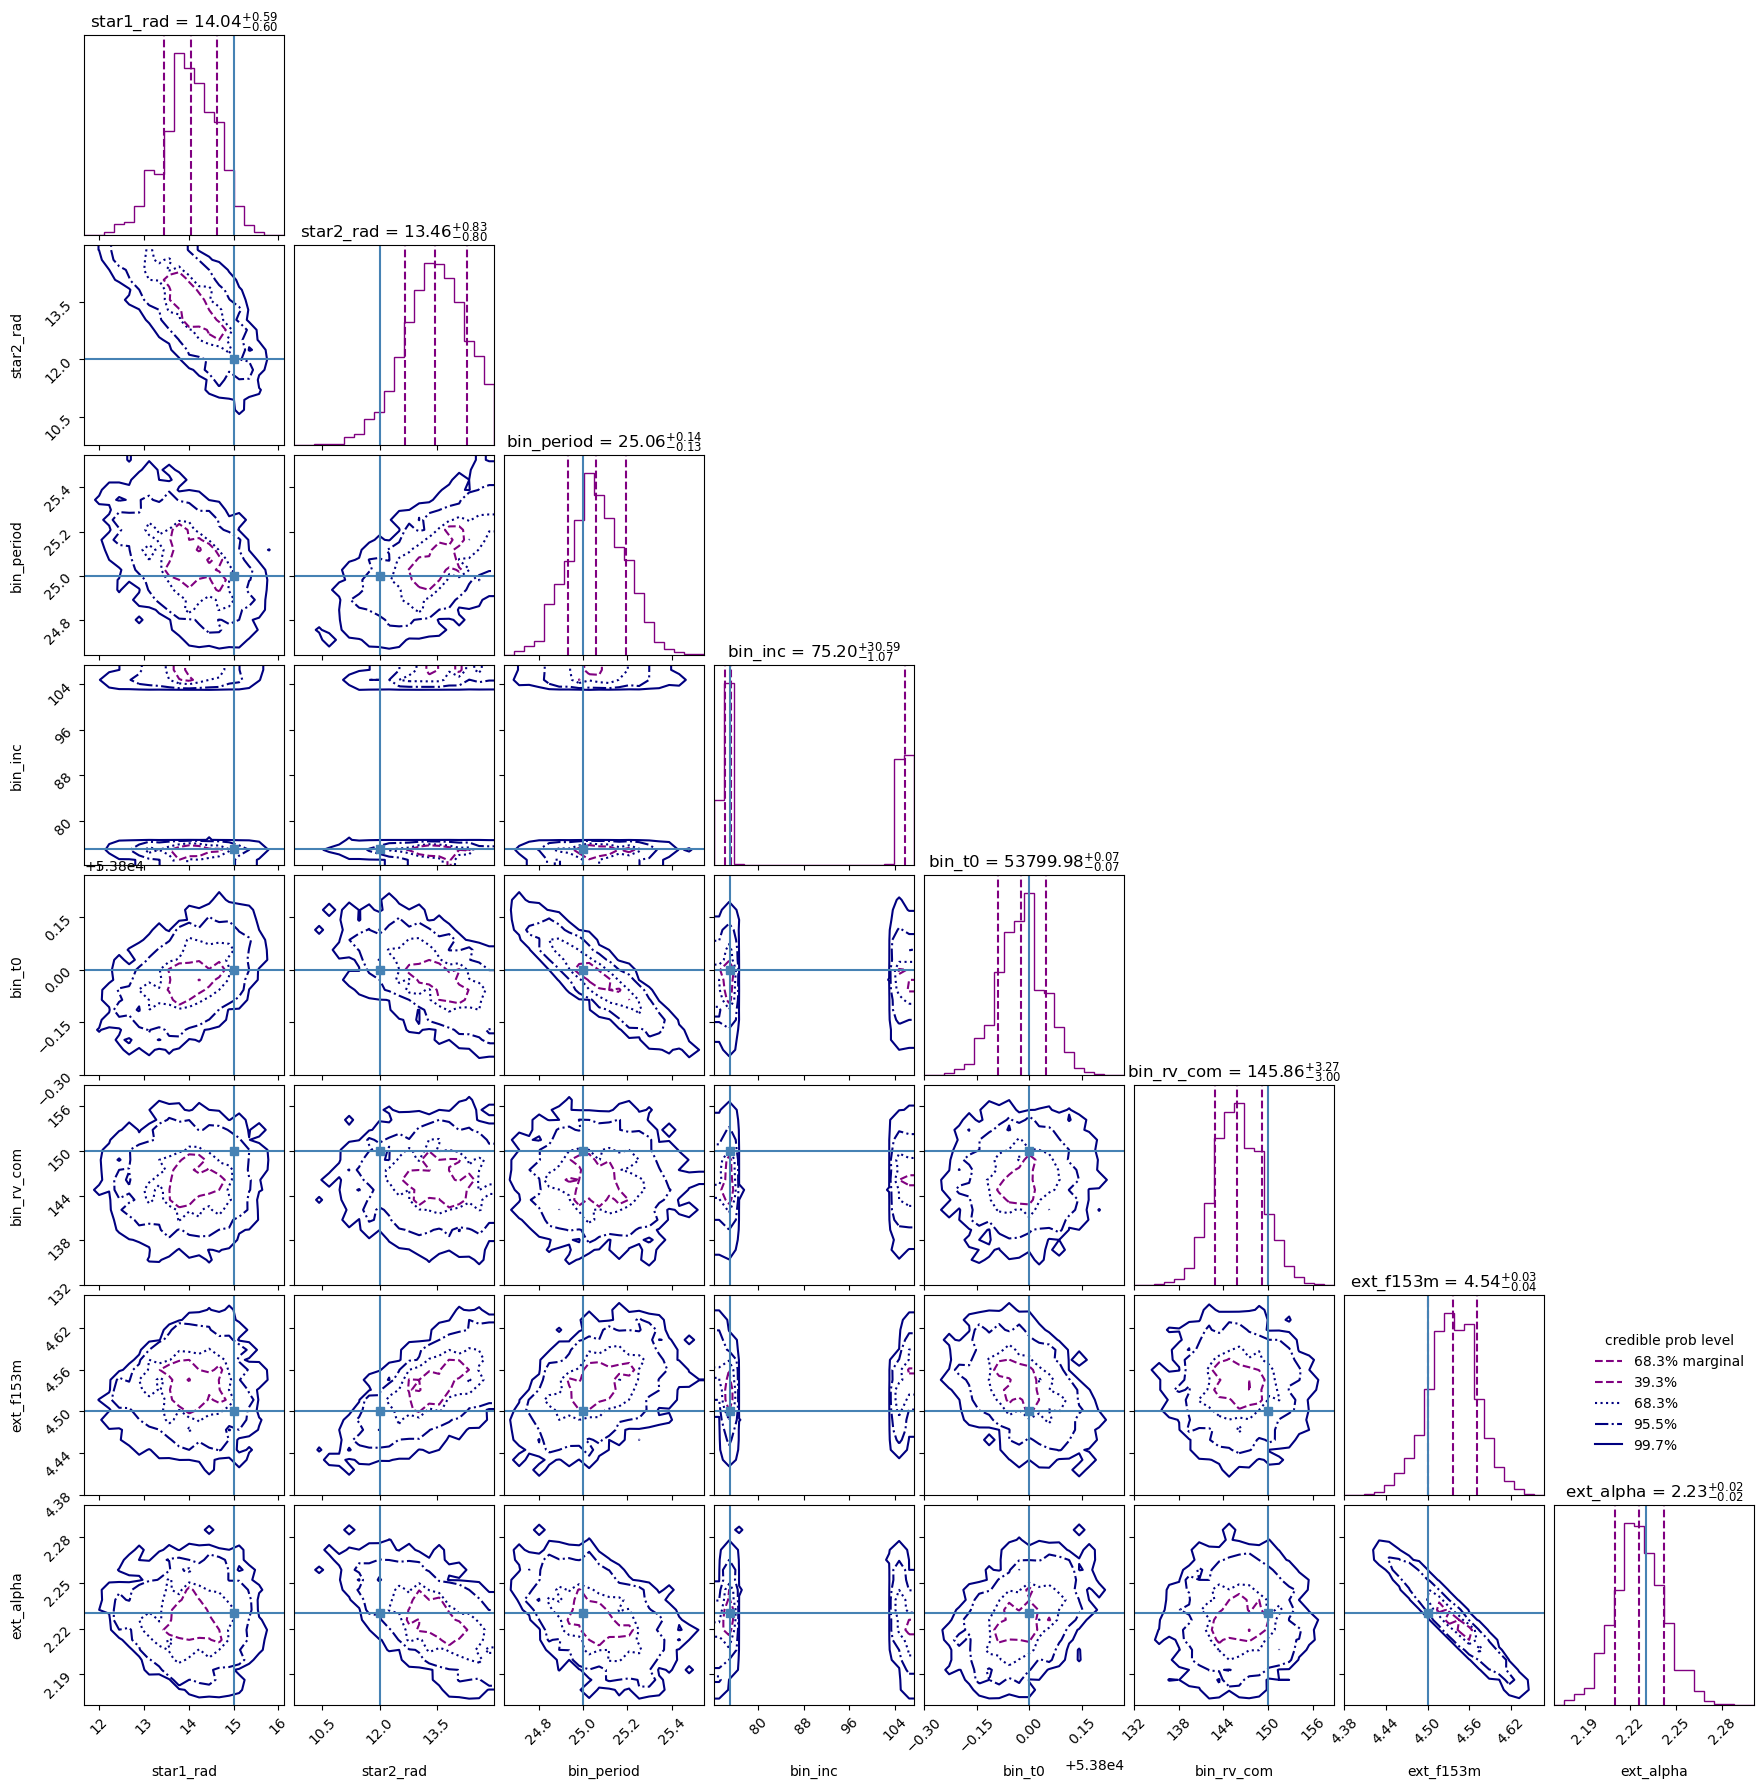

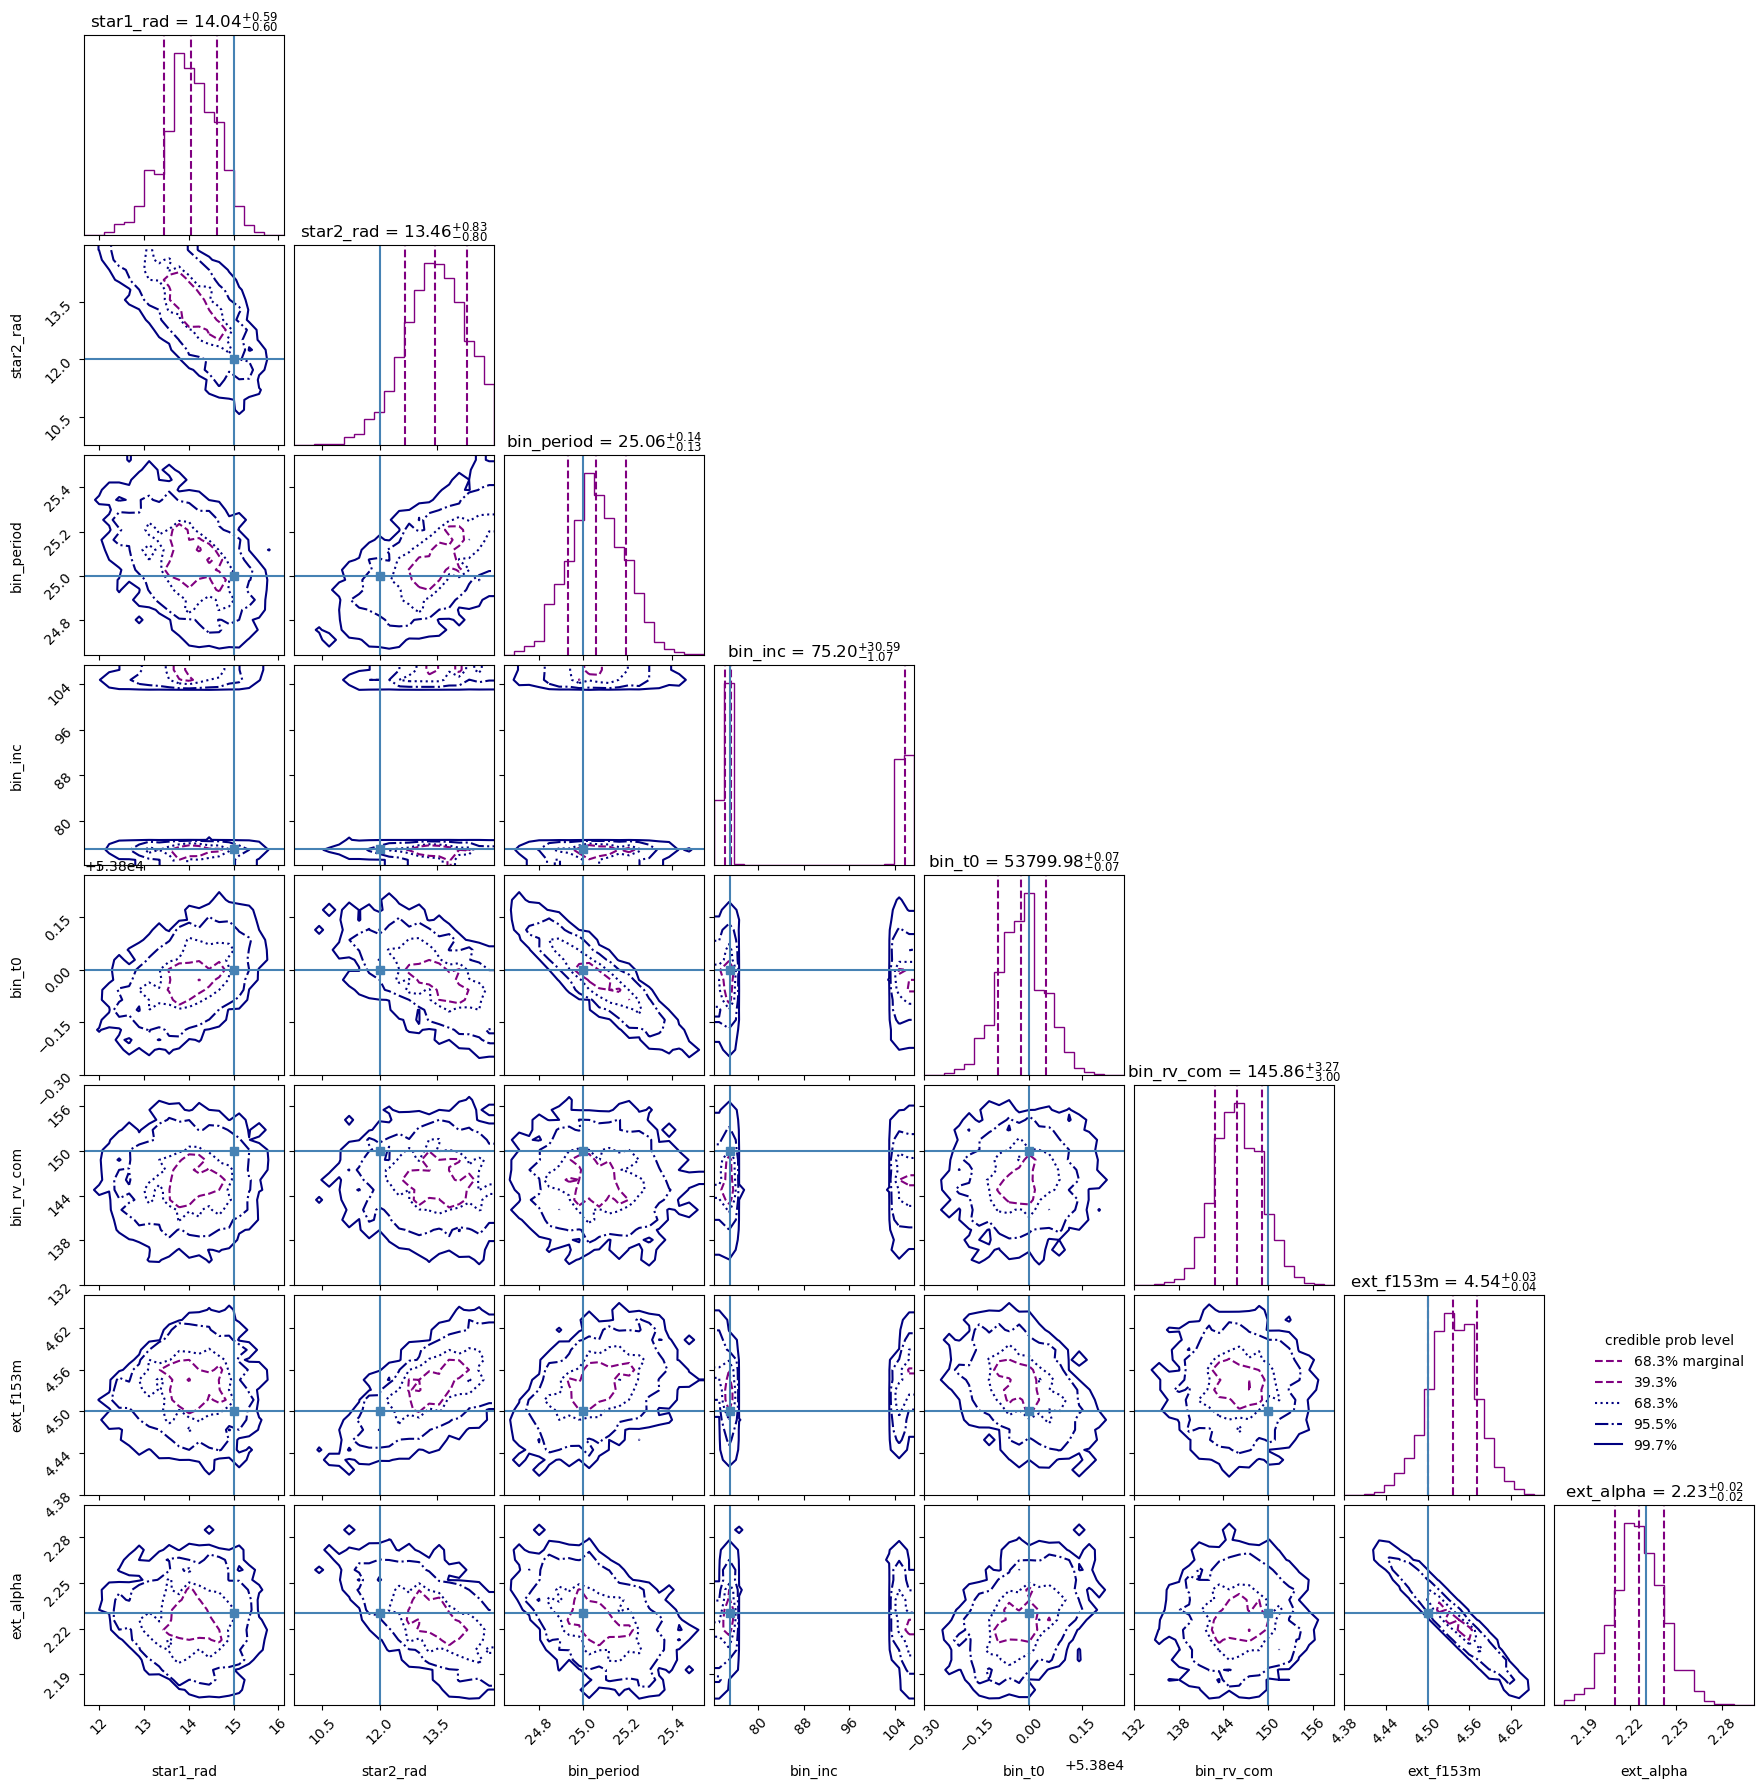

In [15]:
ultranest.plot.cornerplot(sampler.results, truths=truth_params,)